# **1. 데이터셋 준비**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import os
import json
import zipfile
import random
import numpy as np
from PIL import Image

## **1-1. 데이터셋 불러오기**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**이미지 파일 압축 해제**
- 본인 경로를 제대로 설정했는지 확인
- 세션 디스크에 `data > train` 폴더를 만들어두고 압축 해제 진행하셔야 합니다..!
  - 세션 디스크 내 임시 경로로, 드라이브 x

```
!unzip (데이터 경로) -d (압축 해제할 경로)
```

In [2]:
### 이미지 파일 압축 해제

!unzip /content/drive/MyDrive/Euron/6th-project2/final/data/train.zip -d /content/data2/train
!unzip /content/drive/MyDrive/Euron/6th-project2/final/data/val.zip -d /content/data2/val

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data2/train/image_640.jpg  
  inflating: /content/data2/train/image_6400.jpg  
  inflating: /content/data2/train/image_6401.jpg  
  inflating: /content/data2/train/image_6402.jpg  
  inflating: /content/data2/train/image_6403.jpg  
  inflating: /content/data2/train/image_6404.jpg  
  inflating: /content/data2/train/image_6405.jpg  
  inflating: /content/data2/train/image_6406.jpg  
  inflating: /content/data2/train/image_6407.jpg  
  inflating: /content/data2/train/image_6408.jpg  
  inflating: /content/data2/train/image_6409.jpg  
  inflating: /content/data2/train/image_641.jpg  
  inflating: /content/data2/train/image_6410.jpg  
  inflating: /content/data2/train/image_6411.jpg  
  inflating: /content/data2/train/image_6412.jpg  
  inflating: /content/data2/train/image_6413.jpg  
  inflating: /content/data2/train/image_6414.jpg  
  inflating: /content/data2/train/image_6415.jpg  
  inflating: /content/data2/train/image_6416.jpg

In [3]:
### annotations 파일 준비

coco_train_path = '/content/drive/MyDrive/Euron/6th-project2/final/data/coco_train.json'
coco_val_path = '/content/drive/MyDrive/Euron/6th-project2/final/data/coco_val.json'

## **1-2. Custom Dataset 준비**

In [4]:
### Custom Dataset 클래스 정의

class FashionDataset(Dataset):
  def __init__(self, annotation_file, image_dir, transform = None):
    with open(annotation_file, 'r') as f:
      self.coco_data = json.load(f)
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.coco_data['annotations'])

  def __getitem__(self, idx):
    ## 속성 정보
    annotation = self.coco_data['annotations'][idx]

    ## 이미지
    image_id = annotation['image_id']

    image_info = next((img for img in self.coco_data['images'] if img['id'] == image_id), None)
    image_path = os.path.join(self.image_dir, image_info['file_name'])

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    ## 캡션
    caption = annotation['caption']

    return image, caption

In [5]:
## 데이터셋 준비

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [6]:
train_dataset = FashionDataset(annotation_file = coco_train_path,
                               image_dir = '/content/data2/train',
                               transform = transform)

In [7]:
val_dataset = FashionDataset(annotation_file = coco_val_path,
                               image_dir = '/content/data2/val',
                               transform = transform)

In [8]:
### DataLoader 설정

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)

# **2. Training(fine-tuning)**

In [9]:
!pip install peft

  Using cached peft-0.12.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 k

In [10]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AdamW, get_cosine_schedule_with_warmup

from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import get_peft_model, LoraConfig

## **2-1. model 준비**

In [11]:
### Pre-trained model 불러오기

# 전처리기
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", do_rescale=False)

# 모델
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [12]:
### 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [13]:
### target layer 가져오기
# 특정한 pattern으로 탐색

def get_target_modules(model, patterns):
    target_modules = []
    for name, module in model.named_modules():
        for pattern in patterns:
            if pattern in name:
                target_modules.append(name)
    return target_modules

In [14]:
## 예시
# 조합에 따라 바꿔야함(layer 찍어서 구조 확인해보기)

decoder_patterns = ["self.query", "self.key", "self.value", "intermediate.dense", "output.dense"]
#encoder_patterns = ["self_attn.qkv", "mlp.fc"]

#encoder_modules = get_target_modules(model, encoder_patterns)[-18:] # 마지막 6개 layer만 가져오려고..
                                                                    # 조건에 따라 바꿔야 함
decoder_modules = get_target_modules(model, decoder_patterns)

target_modules = decoder_modules #+encoder_modules

In [15]:
## PEFT + LoRA 설정

## LoRA Configuration
lora_config = LoraConfig(
    r = 16, # LoRA의 rank
    lora_alpha = 32, # LoRA의 alpha
    lora_dropout = 0.05, # LoRA의 dropout 비율
    target_modules = target_modules,
    bias = "none"
)

# LoRA 적용 모델
peft_model = get_peft_model(model, lora_config)

In [16]:
for modules in peft_model.targeted_module_names:
  print(modules) ## 디코더만 있는 것을 확인

text_decoder.bert.encoder.layer.0.attention.self.query
text_decoder.bert.encoder.layer.0.attention.self.key
text_decoder.bert.encoder.layer.0.attention.self.value
text_decoder.bert.encoder.layer.0.attention.output.dense
text_decoder.bert.encoder.layer.0.crossattention.self.query
text_decoder.bert.encoder.layer.0.crossattention.self.key
text_decoder.bert.encoder.layer.0.crossattention.self.value
text_decoder.bert.encoder.layer.0.crossattention.output.dense
text_decoder.bert.encoder.layer.0.intermediate.dense
text_decoder.bert.encoder.layer.0.output.dense
text_decoder.bert.encoder.layer.1.attention.self.query
text_decoder.bert.encoder.layer.1.attention.self.key
text_decoder.bert.encoder.layer.1.attention.self.value
text_decoder.bert.encoder.layer.1.attention.output.dense
text_decoder.bert.encoder.layer.1.crossattention.self.query
text_decoder.bert.encoder.layer.1.crossattention.self.key
text_decoder.bert.encoder.layer.1.crossattention.self.value
text_decoder.bert.encoder.layer.1.crossatt

## **2-2. 평가 지표 준비**

In [17]:
!git clone https://github.com/salaniz/pycocoevalcap
!pip install git+https://github.com/salaniz/pycocoevalcap.git

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (424/424), done.
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-jso4sdan
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-jso4sdan
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=59951e3e0ce221e36137c8360477a8b0af5dfc655754bfe983cff702fccc05d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrfx9e61/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fe

In [18]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [19]:
### 평가 지표 계산

def compute_metrics(preds, labels):
  scorers = [
      (Bleu(4), "BLEU-4"),
      (Meteor(), "METEOR"),
      (Rouge(), "ROUGE"),
      (Cider(), "CIDEr"),
      (Spice(), "SPICE")
  ]

  results = {}
  for scorer, method in scorers:
    score, _ = scorer.compute_score({i: [labels[i]] for i in range(len(labels))}, {i: [preds[i]] for i in range(len(preds))})
    results[method] = score if isinstance(score, float) else score[-1]

  return results

## **2-3. 학습 및 검증**

In [20]:
### 옵티마이저 및 Learning Rate Schedule 정의

## 옵티마이저
optimizer = AdamW(filter(lambda p: p.requires_grad, peft_model.parameters()),
                  lr = 2e-5, weight_decay = 0.05)

## learning rate schedule
num_training_steps = len(train_loader) * 10  # 10 에포크
num_warmup_steps = int(0.1 * num_training_steps)  # Warmup 비율 10%
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
## 학습 및 검증 손실, 평가 지표 기록

train_losses = []
val_losses = []
best_val_loss = float('inf')

bleu_scores = []
meteor_scores = []
rouge_scores = []
cider_scores = []
spice_scores = []

In [22]:
### 학습을 위한 함수

def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs):
  global best_val_loss

  for epoch in range(num_epochs):
    print(f"=== Epoch {epoch+1} ===")
    print("-" * 20)

    ## Training loop
    model.train()  # 모델 학습 모드로 설정
    epoch_train_loss = 0

    for batch_idx, (images, captions) in enumerate(tqdm(train_loader, desc = f"Training Epoch {epoch+1}/{num_epochs}")):
      images = images.to(device)

      # 전처리
      inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(device)

      # 모델에 입력
      outputs = model(**inputs, labels = inputs.input_ids)

      # 손실 계산 및 역전파
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()  # Learning rate 스케줄링

      epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.4f}")


    ## Validation loop
    model.eval()  # 모델 평가 모드로 설정
    epoch_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, captions in tqdm(val_loader, desc = "Validation"):
        images = images.to(device)
        inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(device)

        outputs = model(**inputs, labels = inputs.input_ids)
        loss = outputs.loss
        epoch_val_loss += loss.item()

        # Generate captions
        generated_ids = model.generate(pixel_values = inputs.pixel_values, max_length = 30)
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens = True)

        # Collect predictions and labels for evaluation
        all_preds.extend(generated_texts)
        all_labels.extend(captions)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss:.4f}")

    ## Calculate evaluation metrics
    metrics = compute_metrics(all_preds, all_labels)

    bleu_scores.append(metrics['BLEU-4'])
    meteor_scores.append(metrics['METEOR'])
    rouge_scores.append(metrics['ROUGE'])
    cider_scores.append(metrics['CIDEr'])
    spice_scores.append(metrics['SPICE'])

    print(f"BLEU: {metrics['BLEU-4']:.4f}, METEOR: {metrics['METEOR']:.4f}, ROUGE: {metrics['ROUGE']:.4f}, CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}")


    ## Best model 저장
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), "/content/drive/MyDrive/Euron/6th-project2/final/model/model_trial_1.pth") # 모델명 trial에 맞게 바꿔주세요.
      print(f"Model saved at Epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    ## Clear cache
    torch.cuda.empty_cache()

In [23]:
# 모델 학습

num_epochs = 10
train(peft_model, train_loader, val_loader, optimizer, scheduler, device, num_epochs)

=== Epoch 1 ===
--------------------


Training Epoch 1/10: 100%|██████████| 625/625 [15:08<00:00,  1.45s/it]


Epoch 1, Average Training Loss: 6.0103


Validation: 100%|██████████| 63/63 [04:41<00:00,  4.47s/it]


Epoch 1, Average Validation Loss: 5.1238
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
{'testlen': 17527, 'reflen': 21189, 'guess': [17527, 16527, 15527, 14527], 'correct': [4048, 508, 60, 7]}
ratio: 0.8271744773231003
BLEU: 0.0087, METEOR: 0.0659, ROUGE: 0.1628, CIDEr: 0.1386, SPICE: 0.0707
Model saved at Epoch 1 with Validation Loss: 5.1238
=== Epoch 2 ===
--------------------


Training Epoch 2/10: 100%|██████████| 625/625 [15:12<00:00,  1.46s/it]


Epoch 2, Average Training Loss: 4.9950


Validation: 100%|██████████| 63/63 [04:40<00:00,  4.46s/it]


Epoch 2, Average Validation Loss: 4.8271
{'testlen': 18488, 'reflen': 21189, 'guess': [18488, 17488, 16488, 15488], 'correct': [4336, 590, 97, 18]}
ratio: 0.8725281985935687
BLEU: 0.0132, METEOR: 0.0754, ROUGE: 0.1701, CIDEr: 0.1947, SPICE: 0.0793
Model saved at Epoch 2 with Validation Loss: 4.8271
=== Epoch 3 ===
--------------------


Training Epoch 3/10: 100%|██████████| 625/625 [15:11<00:00,  1.46s/it]


Epoch 3, Average Training Loss: 4.8203


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.50s/it]


Epoch 3, Average Validation Loss: 4.7381
{'testlen': 19622, 'reflen': 21189, 'guess': [19622, 18622, 17622, 16622], 'correct': [4636, 677, 120, 22]}
ratio: 0.9260465335786999
BLEU: 0.0154, METEOR: 0.0819, ROUGE: 0.1755, CIDEr: 0.2197, SPICE: 0.0836
Model saved at Epoch 3 with Validation Loss: 4.7381
=== Epoch 4 ===
--------------------


Training Epoch 4/10: 100%|██████████| 625/625 [15:12<00:00,  1.46s/it]


Epoch 4, Average Training Loss: 4.7450


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.51s/it]


Epoch 4, Average Validation Loss: 4.6919
{'testlen': 19829, 'reflen': 21189, 'guess': [19829, 18829, 17829, 16829], 'correct': [4781, 725, 132, 25]}
ratio: 0.9358157534569382
BLEU: 0.0167, METEOR: 0.0839, ROUGE: 0.1803, CIDEr: 0.2251, SPICE: 0.0856
Model saved at Epoch 4 with Validation Loss: 4.6919
=== Epoch 5 ===
--------------------


Training Epoch 5/10: 100%|██████████| 625/625 [15:10<00:00,  1.46s/it]


Epoch 5, Average Training Loss: 4.6988


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.49s/it]


Epoch 5, Average Validation Loss: 4.6619
{'testlen': 19665, 'reflen': 21189, 'guess': [19665, 18665, 17665, 16665], 'correct': [4723, 717, 136, 31]}
ratio: 0.9280758884326336
BLEU: 0.0176, METEOR: 0.0835, ROUGE: 0.1772, CIDEr: 0.2413, SPICE: 0.0850
Model saved at Epoch 5 with Validation Loss: 4.6619
=== Epoch 6 ===
--------------------


Training Epoch 6/10: 100%|██████████| 625/625 [15:10<00:00,  1.46s/it]


Epoch 6, Average Training Loss: 4.6747


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.49s/it]


Epoch 6, Average Validation Loss: 4.6435
{'testlen': 20520, 'reflen': 21189, 'guess': [20520, 19520, 18520, 17520], 'correct': [4890, 786, 142, 27]}
ratio: 0.9684270140166611
BLEU: 0.0178, METEOR: 0.0858, ROUGE: 0.1795, CIDEr: 0.2398, SPICE: 0.0834
Model saved at Epoch 6 with Validation Loss: 4.6435
=== Epoch 7 ===
--------------------


Training Epoch 7/10: 100%|██████████| 625/625 [15:11<00:00,  1.46s/it]


Epoch 7, Average Training Loss: 4.6573


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.51s/it]


Epoch 7, Average Validation Loss: 4.6327
{'testlen': 20541, 'reflen': 21189, 'guess': [20541, 19541, 18541, 17541], 'correct': [4856, 780, 147, 37]}
ratio: 0.9694180942941635
BLEU: 0.0193, METEOR: 0.0861, ROUGE: 0.1782, CIDEr: 0.2413, SPICE: 0.0849
Model saved at Epoch 7 with Validation Loss: 4.6327
=== Epoch 8 ===
--------------------


Training Epoch 8/10: 100%|██████████| 625/625 [15:10<00:00,  1.46s/it]


Epoch 8, Average Training Loss: 4.6431


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.50s/it]


Epoch 8, Average Validation Loss: 4.6268
{'testlen': 20480, 'reflen': 21189, 'guess': [20480, 19480, 18480, 17480], 'correct': [4889, 778, 145, 27]}
ratio: 0.9665392420595136
BLEU: 0.0178, METEOR: 0.0864, ROUGE: 0.1793, CIDEr: 0.2465, SPICE: 0.0848
Model saved at Epoch 8 with Validation Loss: 4.6268
=== Epoch 9 ===
--------------------


Training Epoch 9/10: 100%|██████████| 625/625 [15:11<00:00,  1.46s/it]


Epoch 9, Average Training Loss: 4.6325


Validation: 100%|██████████| 63/63 [04:44<00:00,  4.51s/it]


Epoch 9, Average Validation Loss: 4.6250
{'testlen': 20591, 'reflen': 21189, 'guess': [20591, 19591, 18591, 17591], 'correct': [4869, 780, 143, 34]}
ratio: 0.9717778092405979
BLEU: 0.0188, METEOR: 0.0860, ROUGE: 0.1787, CIDEr: 0.2432, SPICE: 0.0863
Model saved at Epoch 9 with Validation Loss: 4.6250
=== Epoch 10 ===
--------------------


Training Epoch 10/10: 100%|██████████| 625/625 [15:10<00:00,  1.46s/it]


Epoch 10, Average Training Loss: 4.6280


Validation: 100%|██████████| 63/63 [04:43<00:00,  4.51s/it]


Epoch 10, Average Validation Loss: 4.6248
{'testlen': 20529, 'reflen': 21189, 'guess': [20529, 19529, 18529, 17529], 'correct': [4883, 777, 142, 34]}
ratio: 0.9688517627070192
BLEU: 0.0188, METEOR: 0.0863, ROUGE: 0.1792, CIDEr: 0.2436, SPICE: 0.0868
Model saved at Epoch 10 with Validation Loss: 4.6248


- layer 풀어주는 개수에 따라서 사용되는 리소스가 달라지니, GPU는 알아서 선택적으로 활용하세요.
  - T4도 버티기는 하는데 조금 불안불안하네요,,
  - GPU 종류 선택 자체가 모델링 성능에 미치는 영향은 다른 조건들이 모두 동일하기에 매우 미미함

## **2-3. 결과 확인**

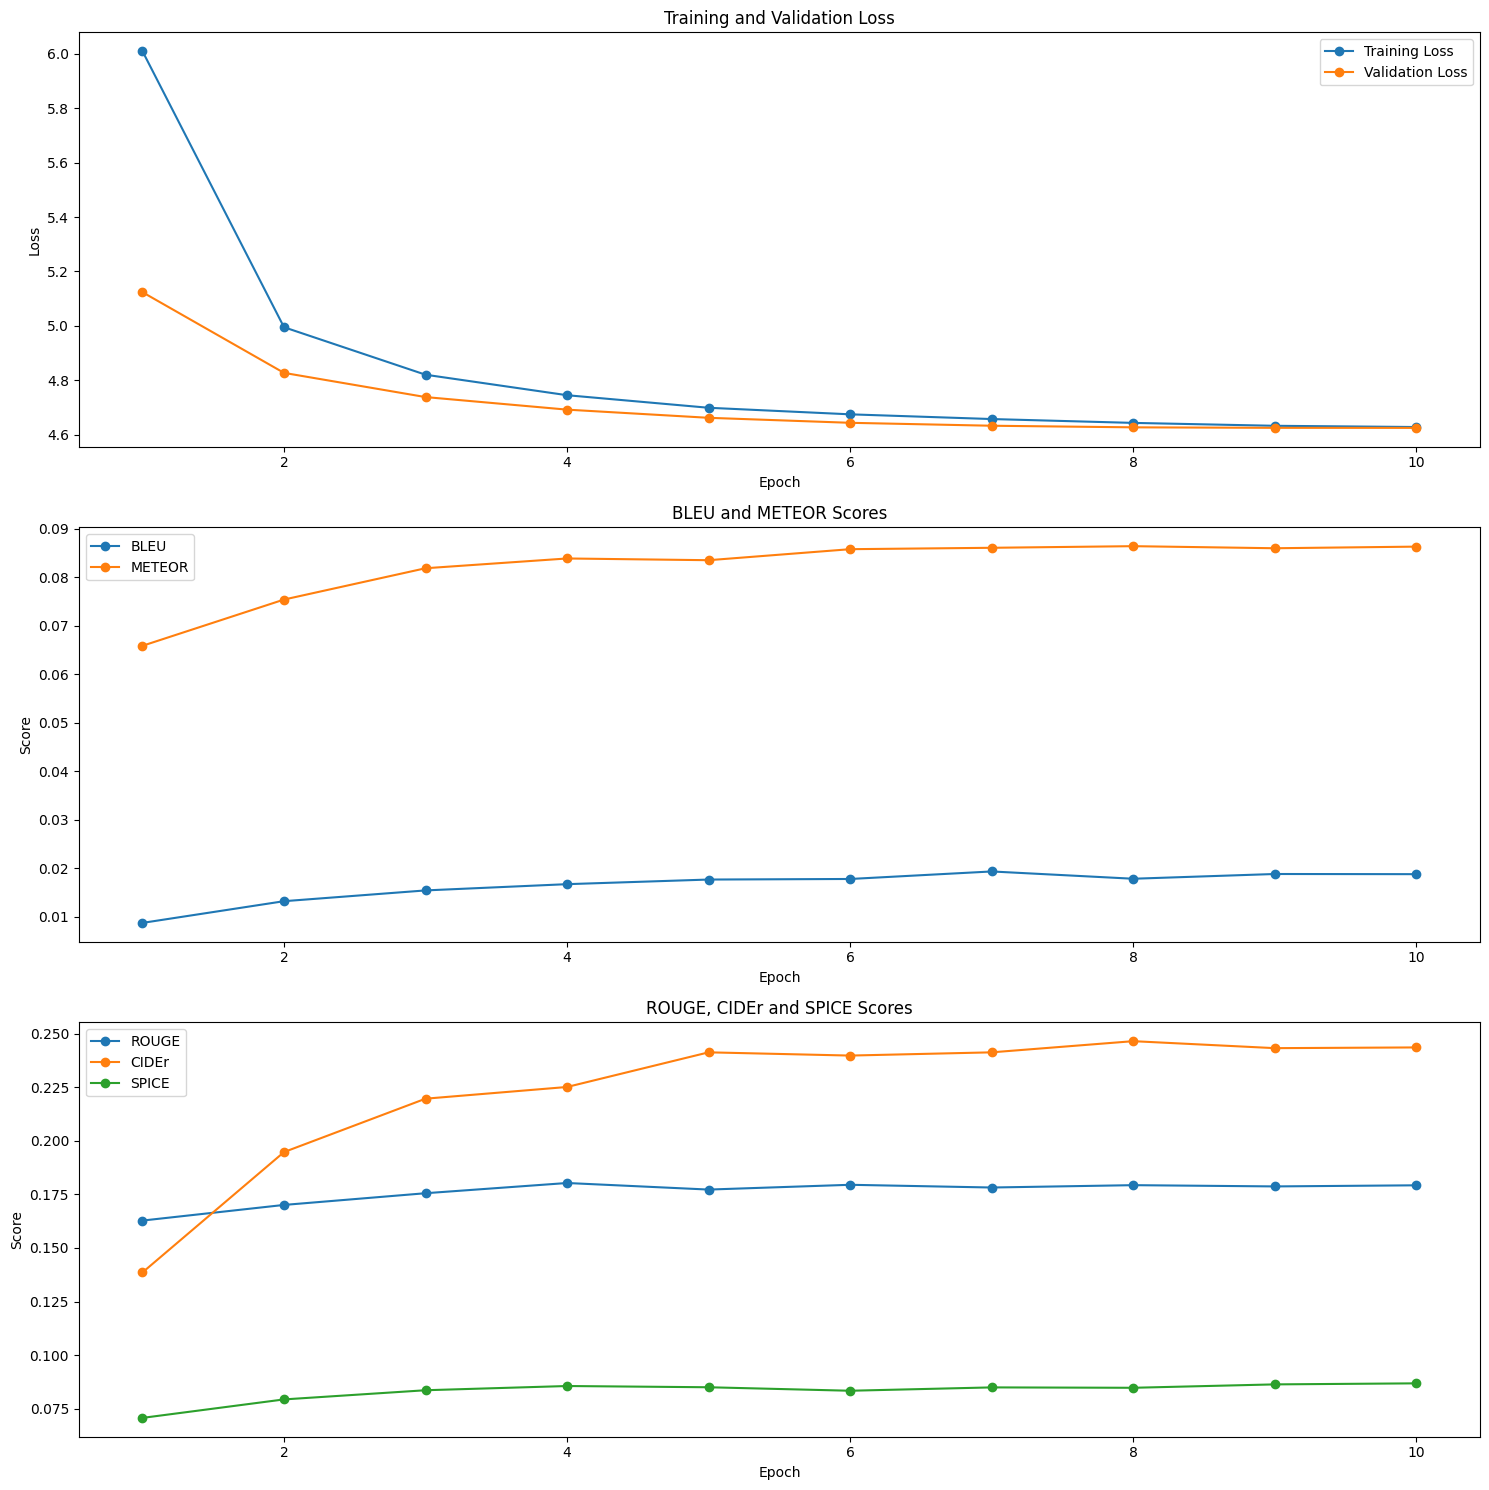

In [24]:
### 시각화
epochs = range(1, num_epochs + 1)

plt.figure(figsize = (15, 15))

# 손실 곡선
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 평가 지표 1 (BLEU, METEOR)
plt.subplot(3, 1, 2)
plt.plot(epochs, bleu_scores, marker='o', label='BLEU')
plt.plot(epochs, meteor_scores, marker='o', label='METEOR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('BLEU and METEOR Scores')
plt.legend()

# 평가 지표 2 (ROUGE, CIDEr, SPICE)
plt.subplot(3, 1, 3)
plt.plot(epochs, rouge_scores, marker='o', label='ROUGE')
plt.plot(epochs, cider_scores, marker='o', label='CIDEr')
plt.plot(epochs, spice_scores, marker='o', label='SPICE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('ROUGE, CIDEr and SPICE Scores')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Euron/6th-project2/final/model/model_trial_1.pth")